<a href="https://colab.research.google.com/github/junyi2022/musa-650-remote-sensing/blob/main/assignments/final/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MUSA 650 Final Assignment: Land Cover Classification of Lake Ontario Shore Using Sentinel 2 of 10m Resolution

## Introduction

This project is based on my current RA project, *New York Healthy Coasts and Communities: Passive Sediment Management Study for New York's Lake Erie Shoreline*, which focuses on the application of an Operational Landscape Unit (OLU) process to assist in identifying and prioritizing particular sites and coastal resilience-related strategies that might be most applicable in certain areas. The area of study is the Lake Erie shore of New York

This project started in fall 2023 and has continued for two years now. In the future, we are going to apply a similar method to Lake Ontario in New York State. In the current project, one of the datasets that I prepared is the 10m landcover classification of Lake Erie using Sentinel 2 images, and I did all the modeling steps in ArcGIS, which is hard to manipulate because GIS always has bugs, and is time-consuming because I hand-label everything. If we decide to apply the whole tool to Lake Ontario in the near future, I have to prepare the land cover classification for Lake Ontario as well.

Since I was introduced to geemap this semester, I think it is a good opportunity to test an easier workflow to make the whole process easier, specifically the training sample generation process and modeling process. Because it is a test on workflow and because of the sentinel data limitation on geemap, I will not perform the classification for the whole shoreline. Instead, a smaller area that contains sentinel data on geemap will be used for modeling.

### Problem Identification

Since this project is closely related to the Lake Erie project, I would expand more on the problem and solution for that project. The problem and solution for the Lake Ontario project will be the same.

For people who live along the shoreline of the Great Lakes, there are a lot of issues related to sediment loss/accumulation or shoreline erosion that need coastal engineering work to mitigate. However, the decision about which method to use is hard because a very general method may not be effective, and a very site-specific method may be too expensive to afford. In this way, the project designed a web tool to help people make such decisions. It will evaluate multiple datasets based on the user's preference and provide customized suggestions to them. The land cover data is one of the data sources used. One of the functions of the tool is to help the user find similar land along the shore to the user's house or point of interest and see what projects are constructed there, with the idea that similar shoreline conditions will need similar methods.

The reason why this project doesn't use the existing NLCD data is that the NLCD is in 30m resolution, which is too coarse for the coastal condition. Even though there are also existing 10m resolution land cover data, such as ESA, those are not in a satisfied accuracy.

### Target User(s)

One obvious target user in this case is the resident who has a house close to the shore and is worried about losing the house because of the shoreline erosion. The tool can help them find useful engineering methods to protect the shoreline near their houses.

Another target user is the regional government and non-profit organizations such as the Waterkeeper. The tool can help them make better decisions to regulate the area and prevent disasters.

## Solution Development

### Data and Model

- **Data Source**:
  - **Sentinel-2 Level2A:** base for landcover analysis
  - **NLCD:** (National Land Cover Database) used for generating labels and result comparison
  - **USGS 10m dem:** elevation data for landcover classification
- **Model Architecture**:
  - The data gathering and modeling part will be mostly on geemap and rasterio
  - Preprocessing steps and feature engineering.(see detailed steps in the following sections)
      - The Sentinel data of 11 bands will be combined with elevation and slope data to generate a composite image. Calculations of NDVI and kernel filters will be added to that composite image as well to generate a total of **36 bands**.
      - The project focuses on five land cover categories: **urban, agriculture, water, vegetation, and sand.**
      - Training points are automatically generated through nlcd data. Because of the resolution mismatch, the points from 30m resolution NLCD data may be wrong on the 10m resolution Sentinel image. Therefore, the points will be exported to ArcGIS for manual check.
      - With the updated training samples from ArcGIS, this project will test multiple models and select the one that works the best for later prediction. The models and tests are: **random forest all features, random forest top features, XGBoost all features, XGBoost top features, CatBoost top features, SVM**
      - After selecting the best model, we will make a prediction with it and evaluate the result. We will also compare it with the NLCD data.
  - There are a lot of potential models to use, and this project selects some common ones. It also doesn't use deep learning models. The best model is selected based on accuracy and variability of the cross validation tests.
- **Scaling Considerations**:
  - **Cloud Computing and GPUs**: Even though I only select a smaller area along the shore, the size of the image is still large, especially for a composite image with 36 bands. The calculations take a lot of RAM on Colab, and need GPU to process. Fortunately, I have bought compute units on Colab.
  - **Training Constraints**: Since geemap is cloud-based, the processing time won't be a big problem for it. I also didn't use deep learning methods, which will save more processing time.

### Relevant Research

The project referenced the Land & Carbon Lab's research: [*Global Land Cover Maps’ Accuracy and Applications Explained*](https://landcarbonlab.org/insights/global-land-cover-maps-accuracy-applications/). It introduces and compares between different existing land cover models and highlights the importance of land cover map for monitoring environmental changes, informing land use planning, and supporting climate and biodiversity goals. However, with the proliferation of various maps, users often face challenges in selecting the most appropriate one for their specific needs. To address this, Land & Carbon Lab, in collaboration with Wageningen University and the University of Maryland, conducted a study examining the accuracies and characteristics of three global land cover datasets at 10-meter resolution. The study highlights the importance of validating these maps, as their accuracy can vary based on factors like geographic region and land cover type.

I specifically check the landcover maps mentioned in their research and found that those are all pretty bad in my area. In this way, I decided to use nlcd to generate training points instead of the existing 10, resolution data.

**Disclaimer:** I consulted the following AI tool to revise code and answer questions for this project.

- DeepSeek. (n.d.). DeepSeek artificial intelligence system. Retrieved from https://www.deepseek.com

**Note:** The output interactive geemap cannot be visualized on GitHub because the 'state' key is missing from 'metadata.widgets'. Although the notebook can be used in Colab, this project decides to use rasterio for its compatibility with GitHub.

## Evaluation

### Quantitative and Qualitative Analysis

- **Evaluation Metrics**: The models are evaluated on precision, recall, f1-score, cross validation accuracy and variability, and confusion matrix. These are all common metrics to evaluate machine learning models.
- **Quantitative Evaluation**: See code section below.
- **Qualitative Analysis**: See code section below.

### Future Steps

The result of the model looks very good. The project ends up using the random forest model with all features as input, and the cross-validation accuracy is **76.72%**. In this way, the future step will be to apply this model to other areas along the shoreline of Lake Ontario and test if this model is generalizable enough. The problem with that is the Sentinel data on geemap does not cover other areas along the shore, so the Sentinel Hub api may be needed for future applications.

**The following part is the step-by-step coding process of this project.**

## 1. Setup

In [133]:
# Import required libraries
import os
import json
import ee
import geemap
import ipywidgets as widgets
from IPython.display import display
from ipyleaflet import GeoJSON

from rasterio.merge import merge
import glob
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import contextily as ctx
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd

from google.colab import drive

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, cohen_kappa_score

# Show all columns
pd.set_option('display.max_columns', None)

Define the color palette that will be used for land cover plots.

In [10]:
class5_palette = ['#DF6149', '#FEDC7B', '#9bcae8', '#6bbf99', '#F5EEDC']

Google Earth Engine requires authentication before usage. Instruction can be found [here](https://developers.google.com/earth-engine/guides/auth). The project is a google cloud project set up in the google cloud account. There is also a notebook autheticator [here](https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/cloud-platform%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=jHMQOVzUM-B-pUwoeKSCPjAqmuPK90lbh-Z2xFjR55o&tc=n8BD6km8I2vhYIau8ww5Hrztwrd5Wulp0qdijy5YqII&cc=Yusop5Cp9Vxq3z_wUl9rzbY_q2YP5o1JUMM4lyLIvJs).

In [11]:
ee.Authenticate()
ee.Initialize(project='ee-musa-remote-sensing')

Create a geemap map.

In [12]:
Map = geemap.Map()

## 2. Data Collection and Feature Engineering

### 2.1 Collecting Data

The region of interest (ROI) of my RA project is generated in ArcGIS with the following steps.
1. Extract the HUC 12 that run into the New York State part of Lake Ontario.
2. Generate a minimum bounding geometry for those HUC 12 along the shoreline.
3. Remove the area that falls into the Canada side.

In [26]:
boundary = gpd.read_file("https://raw.githubusercontent.com/junyi2022/musa-650-remote-sensing/refs/heads/main/assignments/final/import/site_boundary.geojson").to_crs(epsg=3857)
HUC = gpd.read_file("https://raw.githubusercontent.com/junyi2022/musa-650-remote-sensing/refs/heads/main/assignments/final/import/HUC12_Ontario.geojson").to_crs(epsg=3857)

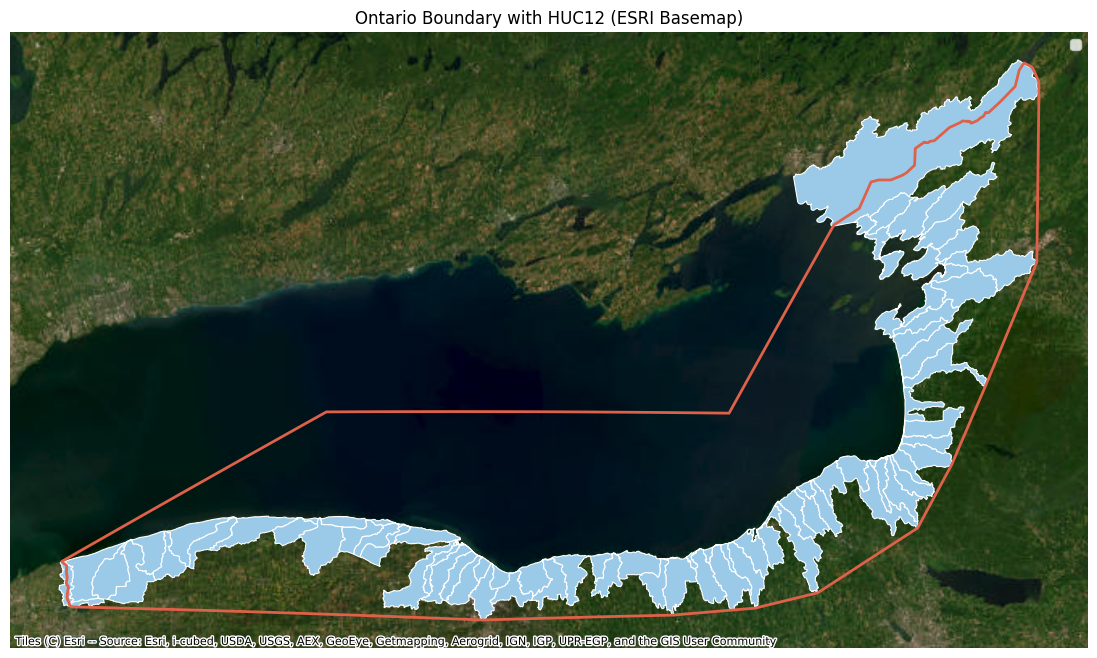

In [32]:
# Create the plot
fig, ax = plt.subplots(figsize=(15, 8))

HUC.plot(ax=ax, color="#9bcae8", edgecolor="white", linewidth=0.8, label="HUC12")
boundary.plot(ax=ax, color="none", edgecolor="#DF6149", linewidth=2, label="Ontario Boundary")

# Add a basemap (OpenStreetMap by default)
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)

# Customize the plot
plt.title("Ontario Boundary with HUC12 (ESRI Basemap)")
plt.legend()
ax.set_axis_off()
plt.show()

However, the boundary is too complicated for geemap to process, and the Sentinel collection images on geemap for this area are very limited. In this way, this project selects a smaller area on the south shore of Lake Ontario to act as a test site, with the hope that the work in this project can be applied to other areas later. The boundary used in this project will be a rectangular area to make it easier for Geemap to calculate.

In [59]:
ontario_region = ee.Geometry.Rectangle([-77.9391, 43.07958, -77.2621, 43.3979])

The satellite data used is [Harmonized Sentinel-2 MSI: MultiSpectral Instrument, Level-2A (SR)](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED). We filter for images with minimal cloud cover. The band used in this project are **B2, B3, B4, B5, B6, B7, B8, B8A, B9, B11, and B12**.

The band info is showed in the form below:

| Name | Units | Min | Max | Scale   | Pixel Size | Wavelength                           | Description    |
|------|-------|-----|-----|---------|------------|---------------------------------------|----------------|
| B1   |       |     |     | 0.0001  | 60 meters  | 443.9nm (S2A) / 442.3nm (S2B)        | Aerosols       |
| B2   |       |     |     | 0.0001  | 10 meters  | 496.6nm (S2A) / 492.1nm (S2B)        | Blue           |
| B3   |       |     |     | 0.0001  | 10 meters  | 560nm (S2A) / 559nm (S2B)            | Green          |
| B4   |       |     |     | 0.0001  | 10 meters  | 664.5nm (S2A) / 665nm (S2B)          | Red            |
| B5   |       |     |     | 0.0001  | 20 meters  | 703.9nm (S2A) / 703.8nm (S2B)        | Red Edge 1     |
| B6   |       |     |     | 0.0001  | 20 meters  | 740.2nm (S2A) / 739.1nm (S2B)        | Red Edge 2     |
| B7   |       |     |     | 0.0001  | 20 meters  | 782.5nm (S2A) / 779.7nm (S2B)        | Red Edge 3     |
| B8   |       |     |     | 0.0001  | 10 meters  | 835.1nm (S2A) / 833nm (S2B)          | NIR            |
| B8A  |       |     |     | 0.0001  | 20 meters  | 864.8nm (S2A) / 864nm (S2B)          | Red Edge 4     |
| B9   |       |     |     | 0.0001  | 60 meters  | 945nm (S2A) / 943.2nm (S2B)          | Water vapor    |
| B11  |       |     |     | 0.0001  | 20 meters  | 1613.7nm (S2A) / 1610.4nm (S2B)      | SWIR 1         |
| B12  |       |     |     | 0.0001  | 20 meters  | 2202.4nm (S2A) / 2185.7nm (S2B)      | SWIR 2         |

When getting the summer images of this area, there is no single year's image that can cover the full area. In this way, after multiple tests, the project combines the 2020 and 2023 images to create a new image that covers the full area. On the other hand, there is no full image in the winter that can cover the full scope of the area, so this project drops the idea of comparing NDVI change between summer and winter.

In [37]:
point = ee.Geometry.Point([-77.2679, 43.2697])

# Cloud masking function
def mask_s2_clouds(image):
    qa = image.select('QA60')
    cloud_bit_mask = 1 << 10
    cirrus_bit_mask = 1 << 11
    mask = qa.bitwiseAnd(cloud_bit_mask).eq(0).And(
           qa.bitwiseAnd(cirrus_bit_mask).eq(0))
    return image.updateMask(mask).divide(10000)

# Visualization parameters
visualization = {
    'min': 0.0,
    'max': 0.3,
    'bands': ['B4', 'B3', 'B2'],
}

In [71]:
def add_cloud_cover(img):
    return img.set('CLOUD_COVER', img.get('CLOUDY_PIXEL_PERCENTAGE'))

merged_summer = ee.ImageCollection([
      ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
      .filterBounds(point)
      .filterDate('2020-06-01', '2020-09-30')
      .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
      .map(mask_s2_clouds)
      .first()
      .select(["B2","B3","B4","B5","B6","B7","B8","B8A","B9","B11","B12"])
      .clip(ontario_region),

    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
      .filterBounds(point)
      .filterDate('2023-06-01', '2023-09-30')
      .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
      .map(mask_s2_clouds)
      .first()
      .select(["B2","B3","B4","B5","B6","B7","B8","B8A","B9","B11","B12"])
      .clip(ontario_region)
])

composite_summer = merged_summer.median().clip(ontario_region)

# Add to map
Map.addLayer(composite_summer, visualization, '2020-2023 Median Summer')

The values for each band are not in the 0-1 range because of the Sentinel-2's dual scaling (both 16-bit AND 10000x scaling combined). Need to rescale back to 0-1 in order to calculate other values later.

In [72]:
# Convert your 0-6.5535 range to proper 0-1 reflectance
composite_summer = composite_summer.clamp(0, 1).divide(6.5535)

Check image properties to make sure we have all the bands we need.

In [ ]:
composite_summer.getInfo()

Export for reference on later maunal check on the training points.

In [162]:
# Export image for labeling processing
export_task = ee.batch.Export.image.toDrive(
    image=composite_summer,
    description="composite_summer_export",
    folder="Colab_Files/GEE_Exports/MUSA650_final",
    fileNamePrefix="composite_summer",
    scale=10,
    region=ontario_region,
    crs="EPSG:3857",
    fileFormat="GeoTIFF"
)

export_task.start()
print(export_task.status())

{'state': 'READY', 'description': 'composite_summer_export', 'priority': 100, 'creation_timestamp_ms': 1747000867419, 'update_timestamp_ms': 1747000867419, 'start_timestamp_ms': 0, 'task_type': 'EXPORT_IMAGE', 'id': 'DOLYLTBLU6ATMHVYGBQ7C34H', 'name': 'projects/ee-musa-remote-sensing/operations/DOLYLTBLU6ATMHVYGBQ7C34H'}


### 2.2 Labeling Data

This project uses national landcover database (nlcd) layer as a base to generate training points. The values of the points will be reclassified into **0 for urban, 1 for agriculture, 2 for water, 3 for vegetation, and 4 for sand**. These 5 categories will be used for the remote sensing model.

First, we want to get the original nlcd data, but it has way more categories than we need.

In [17]:
nlcd = ee.Image("USGS/NLCD/NLCD2016").select("landcover").clip(ontario_region)

In [18]:
# NLCD 2016 color palette (matches official NLCD colors)
nlcd_palette = [
    '466b9f',  # Water
    'd1def8',  # Ice/Snow
    'dec5c5',  # Developed, Open Space
    'd99282',  # Developed, Low Intensity
    'eb0000',  # Developed, Medium Intensity
    'ab0000',  # Developed, High Intensity
    'b3ac9f',  # Barren Land
    '68ab5f',  # Deciduous Forest
    '1c5f2c',  # Evergreen Forest
    'b5c58f',  # Mixed Forest
    'af963c',  # Shrub/Scrub
    'ccb879',  # Grassland/Herbaceous
    'dfdfc2',  # Pasture/Hay
    'd1d182',  # Cultivated Crops
    'a3cc51',  # Woody Wetlands
    '82ba9e',  # Emergent Herbaceous Wetlands
]

nlcd_vis = {
    'min': 0,
    'max': 95,  # NLCD has 16 classes (0-95, but not all numbers used)
    'palette': nlcd_palette
}

Map.addLayer(nlcd, nlcd_vis, 'NLCD 2016 Land Cover')

In [19]:
# NLCD class names matching the palette
nlcd_classes = {
    'Water': '466b9f',
    'Ice/Snow': 'd1def8',
    'Developed, Open Space': 'dec5c5',
    'Developed, Low Intensity': 'd99282',
    'Developed, Medium Intensity': 'eb0000',
    'Developed, High Intensity': 'ab0000',
    'Barren Land': 'b3ac9f',
    'Deciduous Forest': '68ab5f',
    'Evergreen Forest': '1c5f2c',
    'Mixed Forest': 'b5c58f',
    'Shrub/Scrub': 'af963c',
    'Grassland/Herbaceous': 'ccb879',
    'Pasture/Hay': 'dfdfc2',
    'Cultivated Crops': 'd1d182',
    'Woody Wetlands': 'a3cc51',
    'Emergent Herbaceous Wetlands': '82ba9e'
}

# Add legend to map
Map.add_legend(
    title="NLCD Land Cover Classification",
    legend_dict=nlcd_classes
)

In [139]:
print(nlcd.get("landcover_class_values").getInfo())

[11, 12, 21, 22, 23, 24, 31, 41, 42, 43, 51, 52, 71, 72, 73, 74, 81, 82, 90, 95]


In this way, we are going to reclassify nlcd data into the 5 categories that we proposed. **0 for urban, 1 for agriculture, 2 for water, 3 for vegetation, and 4 for sand**.

In [145]:
# reclassification rules
reclass_rules = {
    # Original NLCD values : New class
    21: 0, 22: 0, 23: 0, 24: 0,  # Urban (Developed)
    52: 1, 71: 1, 81: 1, 82: 1,  # Agriculture (Barren/Shrub/Grasslands/Crops)
    11: 2,  # Water (Water/Wetlands)
    41: 3, 42: 3, 43: 3, 90: 3, 95: 3,  # Vegetation (Forests)
    31: 4 # Sand
}

# Prepare the remapping inputs
from_values = list(reclass_rules.keys())
to_values = list(reclass_rules.values())

# Reclassify the NLCD image
nlcd_reclassified = nlcd.remap(
    from_values,
    to_values,
    defaultValue=-1  # Default value for any pixels not in the mapping
).rename('class')


In [146]:
Map.addLayer(nlcd_reclassified, {'min': 0, 'max': 4, 'palette': class5_palette}, 'NLCD Land Cover (Reclassified)')

Export the reclassified nlcd data for future reference when checking the training points.

In [147]:
# Export image for labeling processing
export_task = ee.batch.Export.image.toDrive(
    image=nlcd_reclassified,
    description="nlcdReclass_export",
    folder="Colab_Files/GEE_Exports/MUSA650_final",
    fileNamePrefix="nlcd_Reclass",
    scale=30,
    region=ontario_region,
    crs="EPSG:3857",
    fileFormat="GeoTIFF"
)

export_task.start()
print(export_task.status())

{'state': 'READY', 'description': 'nlcdReclass_export', 'priority': 100, 'creation_timestamp_ms': 1747000094330, 'update_timestamp_ms': 1747000094330, 'start_timestamp_ms': 0, 'task_type': 'EXPORT_IMAGE', 'id': 'LQISNY2CZN2IUN2Q6C66NFVD', 'name': 'projects/ee-musa-remote-sensing/operations/LQISNY2CZN2IUN2Q6C66NFVD'}


Generate 1200 to 1400 training points for each landcover category (around 6500 points in total). Here we specifically want a balanced sample so we generate each category separately. The `numPixels` in `sample()` doesn't guarantee the exact count you request - it depends on available valid pixels. In this way, the target count is different for different categories in order to maintain a balanced selection.

In [159]:
# Define target counts per class
target_counts = {
    0: 6000,
    1: 6000,
    2: 4000,
    3: 6000,
    4: 400000
}

samples = []

for class_val, count in target_counts.items():
    # Sample directly from classified pixels
    class_sample = nlcd_reclassified.updateMask(nlcd_reclassified.eq(class_val)) \
        .sample(
            region=ontario_region,
            scale=30,
            numPixels=count,
            seed=3,
            geometries=True
        )
    samples.append(class_sample.map(lambda f: f.set('class', class_val)))

# Combine all samples
points = ee.FeatureCollection(samples).flatten()

# Verify distribution
print("Class distribution:", points.aggregate_histogram('class').getInfo())

Class distribution: {'0': 1432, '1': 1227, '2': 1390, '3': 1262, '4': 1235}


Export the training samples for manual check in ArcGIS.

In [160]:
# Export the full dataset to Google Drive
export_task = ee.batch.Export.table.toDrive(
    collection=points,
    description='trainning_points_export',
    folder='Colab_Files/GEE_Exports/MUSA650_final',
    fileFormat='GeoJSON'
)

# Start the export
export_task.start()

# Check task status (run this later)
print(export_task.status())

{'state': 'READY', 'description': 'trainning_points_export', 'priority': 100, 'creation_timestamp_ms': 1747000536340, 'update_timestamp_ms': 1747000536340, 'start_timestamp_ms': 0, 'task_type': 'EXPORT_FEATURES', 'id': 'H7ZHOB5SZ2DFT2SUNJF7KXPG', 'name': 'projects/ee-musa-remote-sensing/operations/H7ZHOB5SZ2DFT2SUNJF7KXPG'}


At this point, we have exported the reclassified nllcd, the sentinel-2 image, and the training points. We will check in ArcGIS to see if all the training points generated automatically from nlcd are correct. We will import back the updated training points after adjustment in ArcGIS.

### 2.3 Feature Engineering.


#### 2.3.1 NDVI, NDBI, MNDWI

For possible use in the model, calculate and add the following spectral indices:

- **NDVI** (Normalized Difference Vegetation Index)
- **NDBI** (Normalized Difference Built-up Index)
- **MNDWI** (Modified Normalized Difference Water Index)

In [73]:
def add_spectral_indices(img):
    # NDVI - Vegetation index (using B8 and B4)
    ndvi = img.normalizedDifference(['B8', 'B4']).rename('NDVI')

    # NDBI - Built-up index (using B11 and B8)
    ndbi = img.normalizedDifference(['B11', 'B8']).rename('NDBI')

    # MNDWI - Water index (using B3 and B11)
    mndwi = img.normalizedDifference(['B3', 'B11']).rename('MNDWI')

    # Add all indices to the image
    return img.addBands(ndvi).addBands(ndbi).addBands(mndwi)

composite_summer = add_spectral_indices(composite_summer)

#### 2.3.2 Elevation and Slope

Additionally, add elevation and slope data from USGS 10m DEM.

In [74]:
dem = ee.Image("USGS/3DEP/10m").clip(ontario_region)

# Get min/max for the entire region
stats = dem.reduceRegion(
    reducer=ee.Reducer.minMax(),
    geometry=ontario_region,
    scale=10,  # Match DEM resolution (10m)
    maxPixels=1e9
).getInfo()

print(f"Elevation range: {stats['elevation_min']:.2f} - {stats['elevation_max']:.2f} meters")

Elevation range: 72.80 - 227.16 meters


In [75]:
slope = ee.Terrain.slope(dem)
slope_stats = slope.reduceRegion(
    ee.Reducer.minMax(),
    ontario_region,
    100
).getInfo()
print(f"Slope range: {slope_stats['slope_min']:.1f} - {slope_stats['slope_max']:.1f} degrees")

Slope range: 0.0 - 28.6 degrees


Normalize dem and slope to a 0 to 1 scale for consistent model input.

In [77]:
# Extract percentile values
elev_min = stats['elevation_min']
elev_max = stats['elevation_max']
slope_max = slope_stats['slope_max']  # Slope min remains 0

# Normalize using percentiles
elev_norm = dem.clamp(elev_min, elev_max) \
               .unitScale(elev_min, elev_max) \
               .rename('elevation_norm')

slope_norm = slope.clamp(0, slope_max) \
                 .unitScale(0, slope_max) \
                 .rename('slope_norm')

composite_summer = composite_summer.addBands(elev_norm).addBands(slope_norm)

#### 2.3.3 Kernel filters

[Kernel filters](https://google-earth-engine.com/Advanced-Image-Processing/Neighborhood-based-Image-Transformation/) can enhance local spatial patterns like:

- **Edges** between land cover types (great for urban vs. vegetation boundaries)

- **Smoothing** to reduce noise and improve generalization

In [79]:
def add_kernel_filters(img):
    # Edge detection kernels
    sobel_h = ee.Kernel.fixed(3, 3, [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_v = ee.Kernel.fixed(3, 3, [[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    laplacian = ee.Kernel.fixed(3, 3, [[0, 1, 0], [1, -4, 1], [0, 1, 0]])

    # Smoothing kernels
    mean_kernel = ee.Kernel.square(3, 'pixels')
    gaussian_kernel = ee.Kernel.gaussian(radius=3, sigma=1, units='pixels')

    # Optimal bands for filtering in Sentinel-2 (10m and 20m bands)
    bands_to_filter = ['B2', 'B3', 'B4', 'B8']  # Blue, Green, Red, NIR (10m)

    # If you want to include 20m bands as well, you could add:
    # bands_to_filter = ['B2', 'B3', 'B4', 'B8', 'B5', 'B6', 'B7', 'B8A', 'B11', 'B12']

    for band in bands_to_filter:
        # Edge detection
        img = img.addBands(
            img.select(band).convolve(sobel_h).rename(f'{band}_sobel_h'))
        img = img.addBands(
            img.select(band).convolve(sobel_v).rename(f'{band}_sobel_v'))
        img = img.addBands(
            img.select(band).convolve(laplacian).rename(f'{band}_laplacian'))

        # Smoothing
        img = img.addBands(
            img.select(band).convolve(mean_kernel).rename(f'{band}_mean'))
        img = img.addBands(
            img.select(band).convolve(gaussian_kernel).rename(f'{band}_gauss'))

    return img

In [80]:
# Apply to your image
composite_summer = add_kernel_filters(composite_summer)

#### 2.3.4 Data Type Cleanup and Statistics

The bands of composite_summer image need to be in the same data type when exporting. For here we use flost32.

In [81]:
composite_summer = composite_summer.toFloat()

export_task = ee.batch.Export.image.toDrive(
    image=composite_summer,
    description="composite_summer_full",
    folder="Colab_Files/GEE_Exports/MUSA650_final",
    fileNamePrefix="composite_summer_full",
    scale=10,
    region=ontario_region,
    crs="EPSG:3857",
    fileFormat="GeoTIFF"
)

export_task.start()
print(export_task.status())

{'state': 'READY', 'description': 'composite_summer_full', 'priority': 100, 'creation_timestamp_ms': 1747011474609, 'update_timestamp_ms': 1747011474609, 'start_timestamp_ms': 0, 'task_type': 'EXPORT_IMAGE', 'id': '6BAWXCHWZZTFGWPS3RFQJB44', 'name': 'projects/ee-musa-remote-sensing/operations/6BAWXCHWZZTFGWPS3RFQJB44'}


Plot all the statistics.

In [84]:
def get_complete_image_stats(image, region, scale=10):
    """
    Get comprehensive statistics for all bands in an image, including calculated min/max

    Args:
        image: ee.Image to analyze
        region: ee.Geometry for the area to analyze
        scale: resolution in meters

    Returns:
        pandas.DataFrame with complete band statistics
    """
    # Get basic band info
    image_info = image.getInfo()

    # Prepare to collect statistics
    band_stats_list = []

    # Get all band names
    band_names = [band['id'] for band in image_info['bands']]

    # Calculate statistics for all bands at once (more efficient)
    stats = image.reduceRegion(
        reducer=ee.Reducer.minMax().combine(
            reducer2=ee.Reducer.mean(),
            sharedInputs=True
        ).combine(
            reducer2=ee.Reducer.stdDev(),
            sharedInputs=True
        ),
        geometry=region,
        scale=scale,
        bestEffort=True,
        maxPixels=1e9
    ).getInfo()

    # Process each band
    for band in image_info['bands']:
        band_id = band['id']

        # Get calculated statistics
        band_min = stats.get(f'{band_id}_min')
        band_max = stats.get(f'{band_id}_max')
        band_mean = stats.get(f'{band_id}_mean')
        band_std = stats.get(f'{band_id}_stdDev')

        # Create band entry
        band_entry = {
            'band_id': band_id,
            'precision': band['data_type']['precision'],
            'min_value': band_min,
            'max_value': band_max,
            'mean_value': band_mean,
            'std_dev': band_std
        }

        band_stats_list.append(band_entry)

    return pd.DataFrame(band_stats_list)

# Usage example:
df_complete_stats = get_complete_image_stats(composite_summer, ontario_region, scale=90)
df_complete_stats

band_id precision  min_value  max_value  mean_value   std_dev
0               B2     float   0.001312   0.121279    0.007895  0.003649
1               B3     float   0.002548   0.124254    0.010309  0.004302
2               B4     float   0.001602   0.133150    0.008150  0.005473
3               B5     float   0.002434   0.141985    0.013629  0.007342
4               B6     float   0.000244   0.139040    0.029770  0.018609
5               B7     float   0.000000   0.140002    0.035549  0.023187
6               B8     float   0.000000   0.137865    0.036552  0.024099
7              B8A     float   0.000000   0.141390    0.038094  0.025266
8               B9     float   0.000000   0.142351    0.038381  0.025282
9              B11     float   0.000183   0.118700    0.022660  0.014037
10             B12     float   0.000366   0.120409    0.013222  0.009047
11            NDVI     float  -1.000000   0.953333    0.446982  0.366183
12            NDBI     float  -0.816199   1.000000   -0.181319  0.136588
13           MNDWI     float  -0.723297   0.950311   -0.228762  0.336923
14  elevation_norm     float   0.009859   0.940343    0.277363  0.257674
15      slope_norm     float   0.000000   1.000000    0.029731  0.050721
16      B2_sobel_h     float  -0.348547   0.359411   -0.000001  0.009573
17      B2_sobel_v     float  -0.458106   0.383322   -0.000046  0.012334
18    B2_laplacian     float  -0.380499   0.177111   -0.000031  0.006430
19         B2_mean     float   0.001350   0.057040    0.007856  0.002548
20        B2_gauss     float   0.001621   0.078538    0.007882  0.002939
21      B3_sobel_h     float  -0.348119   0.367010   -0.000017  0.009978
22      B3_sobel_v     float  -0.454154   0.386969   -0.000105  0.012773
23    B3_laplacian     float  -0.391073   0.177844   -0.000039  0.006626
24         B3_mean     float   0.001884   0.056536    0.010260  0.003365
25        B3_gauss     float   0.002816   0.079306    0.010292  0.003685
26      B4_sobel_h     float  -0.378790   0.395773   -0.000020  0.013565
27      B4_sobel_v     float  -0.503929   0.435111   -0.000079  0.017346
28    B4_laplacian     float  -0.428336   0.193805   -0.000031  0.008606
29         B4_mean     float   0.001353   0.055777    0.008112  0.003994
30        B4_gauss     float   0.001824   0.086362    0.008137  0.004555
31      B8_sobel_h     float  -0.356390   0.387533   -0.000115  0.028095
32      B8_sobel_v     float  -0.393988   0.357595   -0.000764  0.035365
33    B8_laplacian     float  -0.366629   0.196933   -0.000128  0.017689
34         B8_mean     float   0.000357   0.091802    0.036392  0.022857
35        B8_gauss     float   0.000149   0.106932    0.036498  0.023308

#### 2.3.5 Visualization

Read files from google drive and visualize them.

In [86]:
drive.mount('/content/drive')

Mounted at /content/drive


The composite sentinel image is too large, so during exporting geemap saved it into two files. Therefore, we need to combine them and save as a new tif file. One important thing is that when combining files, all the band names are losed, so we need to manually add them back.

In [161]:
# List all split TIFF files (adjust path pattern)
tif_files = glob.glob('/content/drive/MyDrive/Colab_Files/GEE_Exports/MUSA650_final/composite_summer_full*.tif')

# Open all files and store in a list
src_files = [rasterio.open(file) for file in tif_files]

# Merge all tiles
merged, out_transform = merge(src_files)

# Close all source files
for src in src_files:
    src.close()

# Define output metadata (copy from the first file)
with rasterio.open(tif_files[0]) as src:
    meta = src.meta.copy()

# Update metadata for the merged output
meta.update({
    "height": merged.shape[1],
    "width": merged.shape[2],
    "transform": out_transform
})

# Save the merged GeoTIFF
output_path = "/content/drive/MyDrive/Colab_Files/GEE_Exports/MUSA650_final/composite_summer_full_combine.tif"

# 36 band names in order
band_names = [
    'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12',
    'NDVI', 'NDBI', 'MNDWI', 'elevation_norm', 'slope_norm',
    'B2_sobel_h', 'B2_sobel_v', 'B2_laplacian', 'B2_mean', 'B2_gauss',
    'B3_sobel_h', 'B3_sobel_v', 'B3_laplacian', 'B3_mean', 'B3_gauss',
    'B4_sobel_h', 'B4_sobel_v', 'B4_laplacian', 'B4_mean', 'B4_gauss',
    'B8_sobel_h', 'B8_sobel_v', 'B8_laplacian', 'B8_mean', 'B8_gauss'
]

# Save the merged GeoTIFF with proper band names
with rasterio.open(output_path, "w", **meta) as dst:
    dst.write(merged)
    for i, name in enumerate(band_names):
        dst.set_band_description(i + 1, name)

print(f"Merged file saved to: {output_path}")

Merged file saved to: /content/drive/MyDrive/Colab_Files/GEE_Exports/MUSA650_final/composite_summer_full_combine.tif


Read the combined file for later steps.

In [162]:
sentinel_path = '/content/drive/MyDrive/Colab_Files/GEE_Exports/MUSA650_final/composite_summer_full_combine.tif'

# Open the GeoTIFF file
with rasterio.open(sentinel_path) as src:
    # Read all bands into a NumPy array
    image = src.read()
    bounds = src.bounds
    print("Band names:", src.descriptions)  # Lists band names in order
    print("Number of bands:", src.count)
    metadata = src.meta  # Get metadata
    print(metadata)  # Print metadata

# Display shape of image
print(f"Image shape (bands, height, width): {image.shape}")

Band names: ('B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'NDVI', 'NDBI', 'MNDWI', 'elevation_norm', 'slope_norm', 'B2_sobel_h', 'B2_sobel_v', 'B2_laplacian', 'B2_mean', 'B2_gauss', 'B3_sobel_h', 'B3_sobel_v', 'B3_laplacian', 'B3_mean', 'B3_gauss', 'B4_sobel_h', 'B4_sobel_v', 'B4_laplacian', 'B4_mean', 'B4_gauss', 'B8_sobel_h', 'B8_sobel_v', 'B8_laplacian', 'B8_mean', 'B8_gauss')
Number of bands: 36
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 7538, 'height': 4873, 'count': 36, 'crs': CRS.from_wkt('PROJCS["WGS 84 / Pseudo-Mercator",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Mercator_1SP"],PARAMETER["central_meridian",0],PARAMETER["scale_factor",1],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,

Read the updated training points.

In [89]:
points_path = 'https://raw.githubusercontent.com/junyi2022/musa-650-remote-sensing/refs/heads/main/assignments/final/import/training_points_adjust.geojson'
new_points = ee.FeatureCollection(points_path)

In [90]:
# Load the shapefile
labels = gpd.read_file('https://raw.githubusercontent.com/junyi2022/musa-650-remote-sensing/refs/heads/main/assignments/final/import/training_points_adjust.geojson')
# Reproject to match Landsat (EPSG:3857 Web Mercator)
labels = labels.to_crs('EPSG:3857')
labels.head()

OBJECTID  class                              geometry
0         1    0.0  POINT Z (-8637525.472 5332545.773 0)
1         2    0.0   POINT Z (-8618111.527 5328318.89 0)
2         3    0.0  POINT Z (-8643967.173 5340621.323 0)
3         4    0.0   POINT Z (-8658121.58 5357353.877 0)
4         5    0.0  POINT Z (-8611064.835 5330895.841 0)

Visualize everything together.

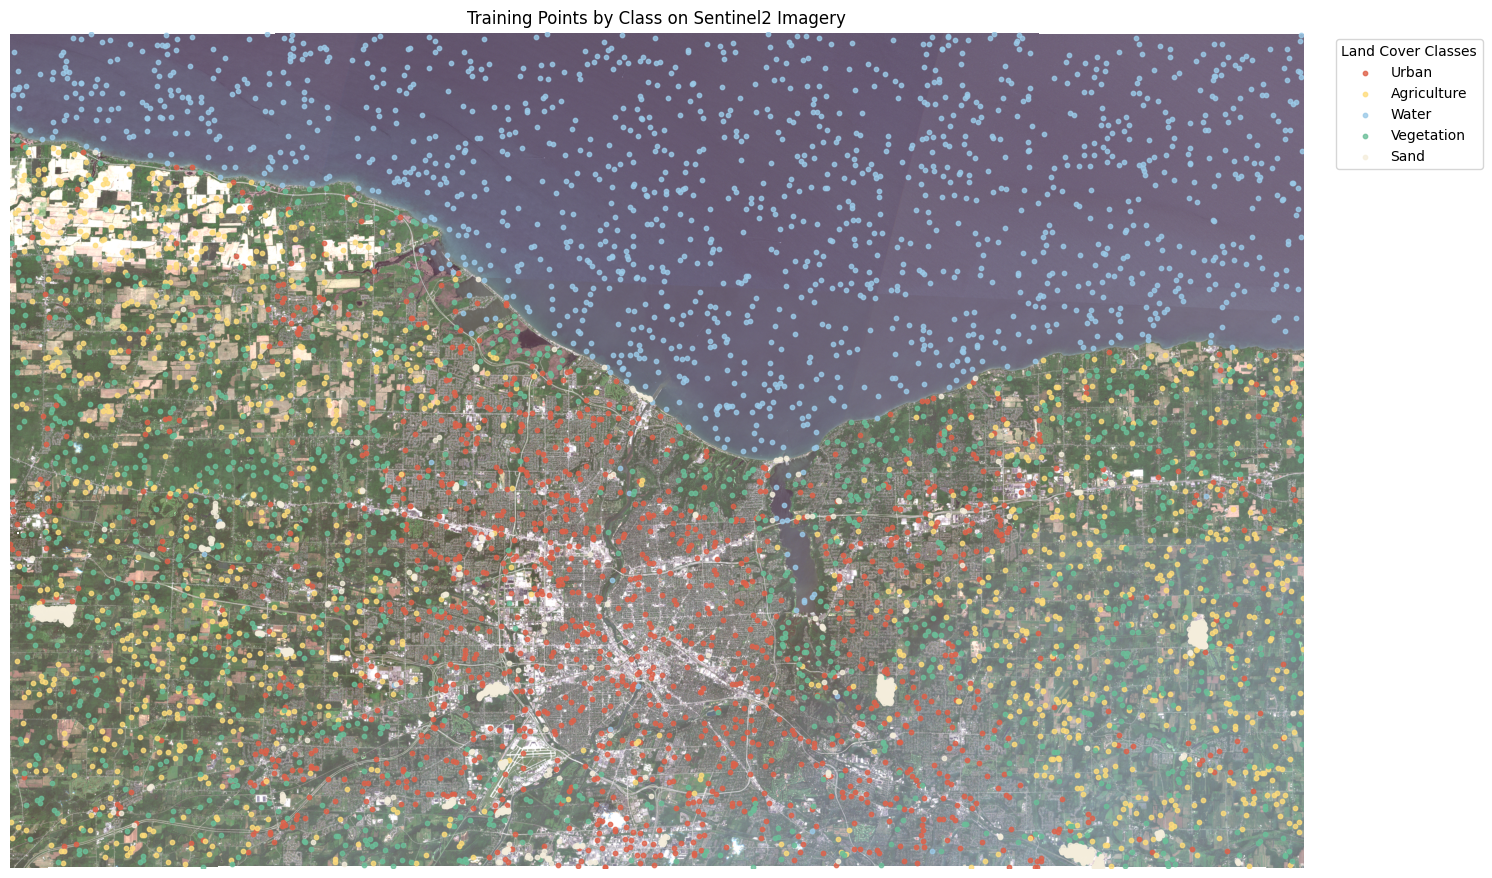

In [103]:
# Select bands for RGB visualization
rgb_bands = [2, 1, 0]  # Sentinel-2 Bands: Red, Green, Blue
rgb = image[rgb_bands].astype('float32')

# Number of standard deviations to stretch (ArcGIS default: 2)
n_std = 3

# Apply standard deviation stretch for each band
for i in range(3):
    band = rgb[i]
    mean = np.nanmean(band)
    std = np.nanstd(band)

    # Define min/max based on ±N standard deviations
    lower = mean - n_std * std
    upper = mean + n_std * std

    # Clip values outside the range and normalize to [0, 1]
    rgb[i] = np.clip((band - lower) / (upper - lower), 0, 1)

# Transpose to [height, width, bands] for plotting
rgb = np.transpose(rgb, (1, 2, 0))

# Plot
fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(rgb, extent=[bounds.left, bounds.right, bounds.bottom, bounds.top])

# Define colors for each class
class_colors = {
    0: class5_palette[0],
    1: class5_palette[1],
    2: class5_palette[2],
    3: class5_palette[3],
    4: class5_palette[4]
}

class_category = {
    0: 'Urban',
    1: 'Agriculture',
    2: 'Water',
    3: 'Vegetation',
    4: 'Sand'
}

# Plot each class separately with its color
for class_val, color in class_colors.items():
    class_points = labels[labels['class'] == class_val]
    if not class_points.empty:
        class_points.plot(
            ax=ax,
            marker='o',
            color=color,
            markersize=10,
            alpha=0.8,
            edgecolor=color,
            linewidth=1,
            label=class_category[class_val]
        )

# Add legend
ax.legend(title='Land Cover Classes', bbox_to_anchor=(1.02, 1), loc='upper left')
ax.axis('off')  # Hide axes

plt.title('Training Points by Class on Sentinel2 Imagery')
plt.tight_layout()
plt.show()

## 3. Model Training and Evaluation

### 3.1 Model Training

#### 3.1.1 Prepare Data for Taining

Before we start training the model, we need to extract the pixel values that each training point is on and put those values in one geodataframe.

In [104]:
# Extract coordinates from GeoJSON
point_coords = [(geom.x, geom.y) for geom in labels.geometry]

# Extract pixel values for all bands
with rasterio.open(sentinel_path) as src:
    pixel_values = list(src.sample(point_coords))  # Returns a generator
    pixel_values = np.array(pixel_values)  # Convert to array [n_points, n_bands]

# Add extracted values to GeoDataFrame
for band in range(pixel_values.shape[1]):
    labels[f'band_{band+1}'] = pixel_values[:, band]  # +1 for 1-based band numbering

labels.head()

OBJECTID  class                              geometry    band_1    band_2  \
0         1    0.0  POINT Z (-8637525.472 5332545.773 0)  0.010559  0.010910   
1         2    0.0   POINT Z (-8618111.527 5328318.89 0)  0.013169  0.015320   
2         3    0.0  POINT Z (-8643967.173 5340621.323 0)  0.003998  0.006470   
3         4    0.0   POINT Z (-8658121.58 5357353.877 0)  0.005676  0.011086   
4         5    0.0  POINT Z (-8611064.835 5330895.841 0)  0.014740  0.017548   

     band_3    band_4    band_5    band_6    band_7    band_8    band_9  \
0  0.009583  0.015625  0.032181  0.039887  0.037354  0.042145  0.055497   
1  0.014496  0.019089  0.037659  0.042008  0.041154  0.044770  0.045777   
2  0.003357  0.009644  0.043275  0.057053  0.058885  0.060349  0.058640   
3  0.009514  0.019516  0.045533  0.053811  0.057122  0.059953  0.061555   
4  0.016358  0.023041  0.038514  0.046159  0.046067  0.049363  0.047456   

    band_10   band_11   band_12   band_13   band_14   band_15   band_16  \
0  0.026108  0.015366  0.591678 -0.177206 -0.410552  0.609486  0.139788   
1  0.029953  0.017288  0.479024 -0.157511 -0.323222  0.601598  0.084025   
2  0.022583  0.009003  0.892130 -0.445589 -0.554622  0.488124  0.020915   
3  0.041115  0.021706  0.714449 -0.162939 -0.575270  0.033974  0.153545   
4  0.035004  0.021180  0.475923 -0.136458 -0.332172  0.527007  0.209427   

    band_17   band_18   band_19   band_20   band_21   band_22   band_23  \
0 -0.009339 -0.019989 -0.004227  0.009368  0.009608 -0.012070 -0.013565   
1 -0.010758 -0.000870 -0.007401  0.011650  0.011696 -0.013657 -0.004837   
2 -0.000748 -0.002548 -0.001511  0.004965  0.003909  0.002487 -0.001083   
3 -0.002419  0.001122  0.000076  0.005338  0.005622 -0.002098  0.000633   
4 -0.002930  0.004150  0.004028  0.013581  0.014942  0.000244  0.002075   

    band_24   band_25   band_26   band_27   band_28   band_29   band_30  \
0  0.005432  0.012134  0.011982 -0.019043 -0.024231  0.002564  0.010229   
1 -0.007553  0.013597  0.013740 -0.020478 -0.007538 -0.010407  0.011760   
2  0.000320  0.007651  0.006722 -0.001282 -0.003845  0.000824  0.005400   
3  0.000145  0.010606  0.010984 -0.003288 -0.001289 -0.001648  0.008038   
4  0.001373  0.016294  0.017398 -0.001892  0.001526  0.002106  0.014867   

    band_31   band_32   band_33   band_34   band_35   band_36  
0  0.010056  0.006790  0.043687  0.013413  0.042684  0.040584  
1  0.012251  0.044419  0.036789  0.017670  0.043604  0.043876  
2  0.003898  0.025330  0.069398 -0.024521  0.046219  0.051181  
3  0.008906  0.002869  0.002121  0.002403  0.058724  0.057858  
4  0.016251  0.006882 -0.019821 -0.011200  0.042370  0.043856

The column name is not helpful for understanding, so now we change the column name to the actual band names. We first generate a dictionary for name reference.

In [105]:
df_complete_stats_with_index = df_complete_stats.reset_index()
df_complete_stats_with_index['index'] = df_complete_stats_with_index['index'] + 1

band_name_mapping = dict(zip(
    df_complete_stats_with_index['index'],
    df_complete_stats_with_index['band_id']
))

print(band_name_mapping)

{1: 'B2', 2: 'B3', 3: 'B4', 4: 'B5', 5: 'B6', 6: 'B7', 7: 'B8', 8: 'B8A', 9: 'B9', 10: 'B11', 11: 'B12', 12: 'NDVI', 13: 'NDBI', 14: 'MNDWI', 15: 'elevation_norm', 16: 'slope_norm', 17: 'B2_sobel_h', 18: 'B2_sobel_v', 19: 'B2_laplacian', 20: 'B2_mean', 21: 'B2_gauss', 22: 'B3_sobel_h', 23: 'B3_sobel_v', 24: 'B3_laplacian', 25: 'B3_mean', 26: 'B3_gauss', 27: 'B4_sobel_h', 28: 'B4_sobel_v', 29: 'B4_laplacian', 30: 'B4_mean', 31: 'B4_gauss', 32: 'B8_sobel_h', 33: 'B8_sobel_v', 34: 'B8_laplacian', 35: 'B8_mean', 36: 'B8_gauss'}


Replace the band number with its real band name that represent what data it is about. The class column needs to be changed to str instead of float.

In [109]:
# Generate new column names
new_columns = []
for col in labels.columns:
    if col.startswith('band_'):
        band_id = int(col.split('_')[1])
        new_name = band_name_mapping.get(band_id, col)  # Fallback to original if not found
        new_columns.append(new_name)
    else:
        new_columns.append(col)  # Keep non-band columns unchanged

# Assign new column names
labels.columns = new_columns

labels['class'] = labels['class'].astype(int).astype(str)

labels.head()

OBJECTID class                              geometry        B2        B3  \
0         1     0  POINT Z (-8637525.472 5332545.773 0)  0.010559  0.010910   
1         2     0   POINT Z (-8618111.527 5328318.89 0)  0.013169  0.015320   
2         3     0  POINT Z (-8643967.173 5340621.323 0)  0.003998  0.006470   
3         4     0   POINT Z (-8658121.58 5357353.877 0)  0.005676  0.011086   
4         5     0  POINT Z (-8611064.835 5330895.841 0)  0.014740  0.017548   

         B4        B5        B6        B7        B8       B8A        B9  \
0  0.009583  0.015625  0.032181  0.039887  0.037354  0.042145  0.055497   
1  0.014496  0.019089  0.037659  0.042008  0.041154  0.044770  0.045777   
2  0.003357  0.009644  0.043275  0.057053  0.058885  0.060349  0.058640   
3  0.009514  0.019516  0.045533  0.053811  0.057122  0.059953  0.061555   
4  0.016358  0.023041  0.038514  0.046159  0.046067  0.049363  0.047456   

        B11       B12      NDVI      NDBI     MNDWI  elevation_norm  \
0  0.026108  0.015366  0.591678 -0.177206 -0.410552        0.609486   
1  0.029953  0.017288  0.479024 -0.157511 -0.323222        0.601598   
2  0.022583  0.009003  0.892130 -0.445589 -0.554622        0.488124   
3  0.041115  0.021706  0.714449 -0.162939 -0.575270        0.033974   
4  0.035004  0.021180  0.475923 -0.136458 -0.332172        0.527007   

   slope_norm  B2_sobel_h  B2_sobel_v  B2_laplacian   B2_mean  B2_gauss  \
0    0.139788   -0.009339   -0.019989     -0.004227  0.009368  0.009608   
1    0.084025   -0.010758   -0.000870     -0.007401  0.011650  0.011696   
2    0.020915   -0.000748   -0.002548     -0.001511  0.004965  0.003909   
3    0.153545   -0.002419    0.001122      0.000076  0.005338  0.005622   
4    0.209427   -0.002930    0.004150      0.004028  0.013581  0.014942   

   B3_sobel_h  B3_sobel_v  B3_laplacian   B3_mean  B3_gauss  B4_sobel_h  \
0   -0.012070   -0.013565      0.005432  0.012134  0.011982   -0.019043   
1   -0.013657   -0.004837     -0.007553  0.013597  0.013740   -0.020478   
2    0.002487   -0.001083      0.000320  0.007651  0.006722   -0.001282   
3   -0.002098    0.000633      0.000145  0.010606  0.010984   -0.003288   
4    0.000244    0.002075      0.001373  0.016294  0.017398   -0.001892   

   B4_sobel_v  B4_laplacian   B4_mean  B4_gauss  B8_sobel_h  B8_sobel_v  \
0   -0.024231      0.002564  0.010229  0.010056    0.006790    0.043687   
1   -0.007538     -0.010407  0.011760  0.012251    0.044419    0.036789   
2   -0.003845      0.000824  0.005400  0.003898    0.025330    0.069398   
3   -0.001289     -0.001648  0.008038  0.008906    0.002869    0.002121   
4    0.001526      0.002106  0.014867  0.016251    0.006882   -0.019821   

   B8_laplacian   B8_mean  B8_gauss  
0      0.013413  0.042684  0.040584  
1      0.017670  0.043604  0.043876  
2     -0.024521  0.046219  0.051181  
3      0.002403  0.058724  0.057858  
4     -0.011200  0.042370  0.043856

Split the data into a training dataset (60%) and a validation dataset (40%).

In [153]:
# Define your feature set and target
features = labels.columns.tolist()[3:]
x = labels[features]
y = labels["class"]

# 60% training, 40% validation
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.4, random_state=42)

#### 3.1.2 Model Testing

#### 3.1.2.1 Model 1: Random Forest Model with all the features

Train a random forest model using the training set with all engineered features.

In [154]:
# Initialize the model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training set
model.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

After training, analyze [variable importance scores](https://stackoverflow.com/questions/74519767/interpreting-variable-importance-from-random-forest-in-gee) to justify each feature's inclusion.

In [150]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for i in range(len(features)):
    print(f"{i+1}. {features[indices[i]]} ({importances[indices[i]]:.4f})")

Feature ranking:
1. B11 (0.0962)
2. B12 (0.0584)
3. B8_mean (0.0577)
4. B9 (0.0529)
5. B8A (0.0497)
6. B5 (0.0445)
7. B4_mean (0.0429)
8. B8_gauss (0.0414)
9. elevation_norm (0.0364)
10. B2_mean (0.0358)
11. B6 (0.0335)
12. B4_gauss (0.0309)
13. MNDWI (0.0302)
14. B8 (0.0266)
15. B3_mean (0.0261)
16. B3_gauss (0.0226)
17. B7 (0.0224)
18. NDVI (0.0215)
19. B2_gauss (0.0207)
20. slope_norm (0.0191)
21. B2 (0.0182)
22. B3 (0.0180)
23. B4 (0.0177)
24. NDBI (0.0171)
25. B8_sobel_v (0.0141)
26. B8_laplacian (0.0139)
27. B4_sobel_v (0.0137)
28. B4_laplacian (0.0136)
29. B2_sobel_h (0.0135)
30. B2_laplacian (0.0132)
31. B2_sobel_v (0.0131)
32. B8_sobel_h (0.0131)
33. B4_sobel_h (0.0130)
34. B3_sobel_h (0.0129)
35. B3_sobel_v (0.0128)
36. B3_laplacian (0.0128)


In [120]:
# Apply 5-fold cross-validation
cv_scores = cross_val_score(model, x_val, y_val, cv=5, scoring='accuracy')

# Compute mean and standard deviation of accuracy
mean_accuracy = cv_scores.mean()
std_accuracy = cv_scores.std()

print(f"Cross-Validation Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}")

Cross-Validation Accuracy: 0.7672 ± 0.0140


Surprisingly, the first model looks pretty good. Likely because of the large number of samples and the manual adjustment of the samples to remove the wrong ones.

We will run it again with more influential features: **B11, B12, B8_mean, B9, B8A, B5, B4_mean, and B8_gauss**

In [129]:
features = ['B11', 'B12', 'B8_mean', 'B9', 'B8A', 'B5', 'B4_mean', 'B8_gauss']
x_2 = labels[features]
y_2 = labels["class"]

# 60% training, 40% validation
x_train_2, x_val_2, y_train_2, y_val_2 = train_test_split(x_2, y_2, test_size=0.4, random_state=42)

# Train the model on the training set
model.fit(x_train_2, y_train_2)

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for i in range(len(features)):
    print(f"{i+1}. {features[indices[i]]} ({importances[indices[i]]:.4f})")

Feature ranking:
1. B12 (0.1504)
2. B5 (0.1486)
3. B11 (0.1371)
4. B8_mean (0.1241)
5. B4_mean (0.1211)
6. B9 (0.1174)
7. B8A (0.1019)
8. B8_gauss (0.0993)


In [130]:
# Apply 5-fold cross-validation
cv_scores = cross_val_score(model, x_val_2, y_val_2, cv=5, scoring='accuracy')

# Compute mean and standard deviation of accuracy
mean_accuracy = cv_scores.mean()
std_accuracy = cv_scores.std()

print(f"Cross-Validation Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}")

Cross-Validation Accuracy: 0.7208 ± 0.0085


The accuracy decreases, which is as expected becuase the model does not have a significant preference on certain features.

#### 3.1.2.2 Model 2: XGBoost

Since the number of samples in the sand category is much less than other categories, we also try the XGBoost model, which handles imbalanced data well.

In [117]:
# Convert string labels to integers
y_train_num = y_train.astype(int)

# Now train XGBoost
model2 = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5)
model2.fit(x_train, y_train_num)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

In [118]:
importances = model2.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for i in range(len(features)):
    print(f"{i+1}. {features[indices[i]]} ({importances[indices[i]]:.4f})")

Feature ranking:
1. B12 (0.1763)
2. B11 (0.0985)
3. B2_mean (0.0928)
4. B4_mean (0.0822)
5. NDBI (0.0774)
6. MNDWI (0.0589)
7. elevation_norm (0.0290)
8. B9 (0.0265)
9. B8A (0.0206)
10. B2_gauss (0.0189)
11. B5 (0.0173)
12. B8_gauss (0.0173)
13. B8_mean (0.0164)
14. slope_norm (0.0160)
15. B4_gauss (0.0142)
16. B3_mean (0.0141)
17. B4 (0.0140)
18. B7 (0.0139)
19. B3_laplacian (0.0135)
20. B4_laplacian (0.0130)
21. B8_laplacian (0.0122)
22. B2_sobel_v (0.0118)
23. NDVI (0.0118)
24. B3_gauss (0.0113)
25. B6 (0.0112)
26. B3_sobel_v (0.0111)
27. B8 (0.0110)
28. B3 (0.0106)
29. B8_sobel_v (0.0104)
30. B3_sobel_h (0.0100)
31. B2 (0.0099)
32. B2_sobel_h (0.0099)
33. B4_sobel_h (0.0097)
34. B4_sobel_v (0.0096)
35. B2_laplacian (0.0095)
36. B8_sobel_h (0.0092)


In [121]:
y_val_num = y_val.astype(int)

# Apply 5-fold cross-validation
cv_scores = cross_val_score(model2, x_val, y_val_num, cv=5, scoring='accuracy')

# Compute mean and standard deviation of accuracy
mean_accuracy = cv_scores.mean()
std_accuracy = cv_scores.std()

print(f"Cross-Validation Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}")

Cross-Validation Accuracy: 0.7652 ± 0.0161


The XGBoost model has similar accuracy as the random forest model, but its feature importance has more preference towards the first couple of features. In this way, we will run it again with the top features: **B12, B11, B2_mean, B4_mean, NDBI, MNDWI**

In [125]:
features = ['B12', 'B11', 'B2_mean', 'B4_mean', 'NDBI', 'MNDWI']
x_2 = labels[features]
y_2 = labels["class"]

# 60% training, 40% validation
x_train_2, x_val_2, y_train_2, y_val_2 = train_test_split(x_2, y_2, test_size=0.4, random_state=42)

y_train_num_2 = y_train_2.astype(int)

# Train the model on the training set
model2.fit(x_train_2, y_train_num_2)

importances = model2.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
for i in range(len(features)):
    print(f"{i+1}. {features[indices[i]]} ({importances[indices[i]]:.4f})")

Feature ranking:
1. B12 (0.2986)
2. B11 (0.1726)
3. B4_mean (0.1551)
4. NDBI (0.1303)
5. B2_mean (0.1302)
6. MNDWI (0.1131)


In [126]:
y_val_num_2 = y_val_2.astype(int)

# Apply 5-fold cross-validation
cv_scores = cross_val_score(model2, x_val_2, y_val_num_2, cv=5, scoring='accuracy')

# Compute mean and standard deviation of accuracy
mean_accuracy = cv_scores.mean()
std_accuracy = cv_scores.std()

print(f"Cross-Validation Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}")

Cross-Validation Accuracy: 0.7344 ± 0.0236


However, this doesn't increase the accuracy.

#### 3.1.2.3 Model 3: CatBoost

Another model tested here is the CatBoost model, but it is not as good as the previous two models becuase it works well with categorical features but our features are not categorical.

In [134]:
# Initialize CatBoost
model3 = CatBoostClassifier(
    iterations=1000,  # Number of boosting rounds (~n_estimators in RF/XGBoost)
    learning_rate=0.1,
    depth=6,  # Tree depth
    loss_function='MultiClass',  # For multiclass classification
    verbose=100,  # Prints training progress every 100 iterations
    random_state=42
)

# Train the model
model3.fit(
    x_train, y_train_num,
    eval_set=(x_val, y_val_num),  # Optional: for early stopping
    early_stopping_rounds=50,  # Stops training if no improvement in 50 rounds
    use_best_model=True
)

0:	learn: 1.4502575	test: 1.4564444	best: 1.4564444 (0)	total: 65.3ms	remaining: 1m 5s
100:	learn: 0.5006541	test: 0.6218159	best: 0.6218159 (100)	total: 1.24s	remaining: 11s
200:	learn: 0.3856472	test: 0.5993271	best: 0.5992914 (199)	total: 2.4s	remaining: 9.53s
300:	learn: 0.3066672	test: 0.5923740	best: 0.5923740 (300)	total: 3.58s	remaining: 8.3s
400:	learn: 0.2474710	test: 0.5888369	best: 0.5882651 (381)	total: 4.75s	remaining: 7.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5868946061
bestIteration = 415

Shrink model to first 416 iterations.


#### 3.1.2.4 Model 4: SVM

In the previous Lake Erie project, the classification used SVM model. Therefore, this project also try the SVM model.

In [140]:
# Standardize features (SVM performs poorly without this!)
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)

In [138]:
model4 = SVC(
    kernel='rbf',       # Radial Basis Function (best for non-linear problems)
    C=10,              # Regularization parameter (higher = less regularization)
    gamma='scale',      # Kernel coefficient ('scale' = 1/(n_features * X.var()))
    random_state=42,
    decision_function_shape='ovr'  # One-vs-Rest for multiclass
)

model4.fit(x_train_scaled, y_train_num)

SVC(C=10, random_state=42)

In [144]:
# Remove NaN rows from features and labels
nan_mask = ~np.isnan(x_val_scaled).any(axis=1)
x_val_clean = x_val_scaled[nan_mask]
y_val_clean = y_val_num[nan_mask]

# Now predict
y_pred = model4.predict(x_val_clean)
print(classification_report(y_val_clean, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.63      0.64       579
           1       0.68      0.69      0.69       473
           2       0.99      0.99      0.99       547
           3       0.76      0.79      0.78       545
           4       0.70      0.70      0.70       351

    accuracy                           0.77      2495
   macro avg       0.76      0.76      0.76      2495
weighted avg       0.76      0.77      0.76      2495



In [145]:
cv_scores = cross_val_score(model4, x_val_clean, y_val_clean, cv=5, scoring='accuracy')

# Compute mean and standard deviation of accuracy
mean_accuracy = cv_scores.mean()
std_accuracy = cv_scores.std()

print(f"Cross-Validation Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}")

Cross-Validation Accuracy: 0.7447 ± 0.0186


In general the SVM is also a good model but is not as good as the random forest model.

#### 3.1.2.5 Summary

For the land cover classification, cross-validation gives a more trustworthy accuracy estimate, especially if some classes (e.g., sand vs. urban) are easily confused. The ± value helps assess if the model performs consistently across different areas of the study region.

The cross-validation accuracy for the four models in this section:
1. **random forest all features:** 76.72% ± 1.4%
2. **random forest top features:** 72.08% ± 0.85%
3. **XGBoost all features:** 76.52% ± 1.61%
4. **XGBoost top features:** 73.44% ± 2.36%
5. **CatBoost top features:** 58.69% (not cross-validation)
6. **SVM:** 74.47% ± 1.86%

The cross-validation results show that **Random Forest (all features)** and **XGBoost (all features)** perform similarly well, with accuracies of **76.72%** and **76.52%**, and relatively low standard deviations. This suggests that both models are stable and effective when using the full feature set. However, when using only the top features, **Random Forest** drops to **72.08%** but with a lower variability, while **XGBoost** maintains a slightly higher accuracy but with greater variability. This indicates that Random Forest may handle feature selection better than XGBoost.  

**SVM** performs reasonably well at **74.47%**, with moderate variability (±1.86%). Meanwhile, **CatBoost (top features)** shows a significantly lower accuracy (**58.69%**), though this result is not cross-validated, making direct comparisons difficult.  

Overall, **Random Forest all features** is the strongest model.

### 3.2 Accuracy Assessment

#### 3.2.1 Predict landcover classification on Sentinel2

Use the trained randopm forest model selected above to classify the sentinel 2 image, creating a land cover classification map with classes for urban, agriculture, water, vegetation, and sand.

In [163]:
def classify_sentinel_image(image_path, model, features, class_category):
    """
    Classify a Sentinel-2 image using a trained RandomForest model

    Args:
        image_path: Path to Sentinel-2 GeoTIFF file
        model: Trained RandomForest classifier
        features: List of features used in training (band names)
        class_category: Dictionary mapping class numbers to names

    Returns:
        classified_image: 2D numpy array with class predictions
        metadata: Original image metadata (for saving output)
    """

    # Open the GeoTIFF file
    with rasterio.open(image_path) as src:
        # Read all bands
        image = src.read()
        metadata = src.meta.copy()

        # Get band names from the image (Sentinel-2 typically has named bands)
        band_names = src.descriptions

        # Reshape the image for classification (from [bands, height, width] to [height*width, bands])
        height, width = image.shape[1], image.shape[2]
        image_reshaped = image.transpose(1, 2, 0).reshape(-1, image.shape[0])

        # Create a dictionary mapping band names to their indices
        band_dict = {name: idx for idx, name in enumerate(band_names)}

        # Extract only the bands used in training (in the correct order)
        feature_indices = [band_dict[feature] for feature in features]
        image_features = image_reshaped[:, feature_indices]

        # Classify the image
        predictions = model.predict(image_features)

        # Reshape predictions back to 2D
        classified_image = predictions.reshape(height, width)

        return classified_image, metadata

In [164]:
# Classify the image
classified_map, metadata = classify_sentinel_image(
    sentinel_path,
    model,
    features,
    class_category=class_category
)

# Update metadata for the classified image (single band, uint8)
metadata.update({
    'count': 1,
    'dtype': 'uint8',
    'nodata': None
})

Before plotting, make sure the classified map is a proper NumPy array with integer type.

In [166]:
classified_map_int = np.array(classified_map, dtype=np.uint8)

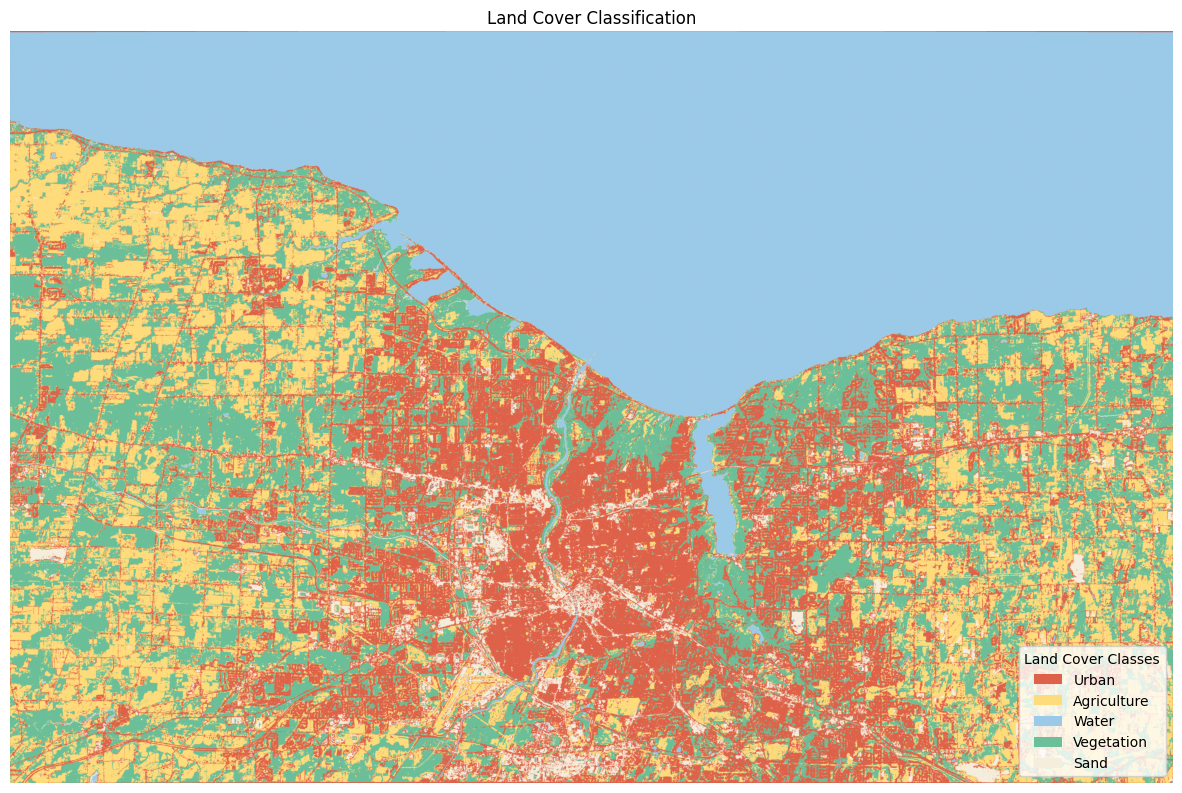

In [167]:
plt.figure(figsize=(15, 10))
cmap = plt.cm.colors.ListedColormap(class5_palette)
plt.imshow(classified_map_int, cmap=cmap)

# Legend
legend_elements = [Patch(facecolor=color, edgecolor=None, label=class_category[i])
                   for i, color in enumerate(class5_palette)]
plt.legend(handles=legend_elements, title='Land Cover Classes', loc='lower right')

plt.title('Land Cover Classification')
plt.axis('off')
plt.show()


#### 3.2.2 Performance evaluation

Using the validation data, generate a confusion matrix and calculate the overall accuracy, precision, and recall.

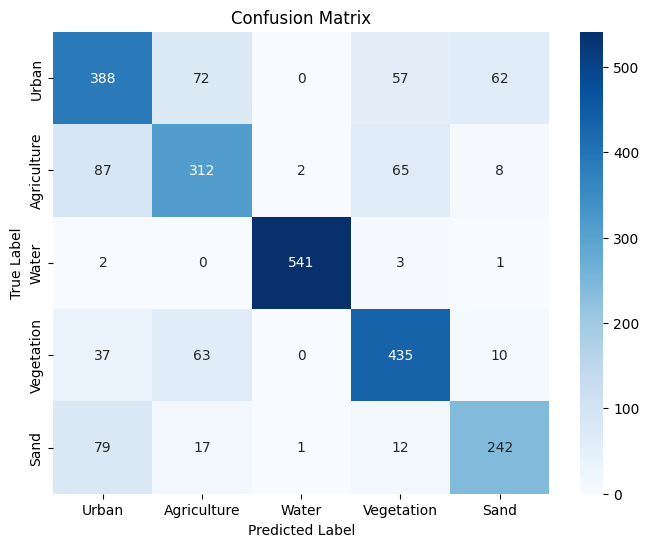

In [168]:
# Predict on validation data
y_pred = model.predict(x_val)

# Generate confusion matrix
cm = confusion_matrix(y_val, y_pred)
class_names = list(class_category.values())

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [170]:
# Core metrics
overall_accuracy = accuracy_score(y_val, y_pred)
kappa = cohen_kappa_score(y_val, y_pred)
cm = confusion_matrix(y_val, y_pred)
report = classification_report(y_val, y_pred, target_names=class_category.values(), output_dict=True)

# 3. Create comprehensive metrics DataFrame
metrics_data = {
    'Metric': ['Overall Accuracy', "Cohen's Kappa"],
    'Value': [overall_accuracy, kappa]
}

# Add per-class metrics
for i, class_name in enumerate(class_category.values()):
    metrics_data['Metric'].extend([
        f'{class_name} Precision',
        f'{class_name} Recall',
        f'{class_name} F1-Score'
    ])
    metrics_data['Value'].extend([
        report[class_name]['precision'],
        report[class_name]['recall'],
        report[class_name]['f1-score']
    ])

metrics_df = pd.DataFrame(metrics_data)

# 4. Create confusion matrix DataFrames
cm_df = pd.DataFrame(cm,
                    index=[f"True {name}" for name in class_category.values()],
                    columns=[f"Pred {name}" for name in class_category.values()])

cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
cm_percent_df = pd.DataFrame(cm_percent.round(1),
                           index=cm_df.index,
                           columns=cm_df.columns)

# 6. Print summary to console
print("\n" + "="*50)
print("Classification Accuracy Report")
print("="*50)
print(f"\nOverall Accuracy: {overall_accuracy:.4f}")
print(f"Cohen's Kappa: {kappa:.4f}\n")

print("Per-Class Metrics:")
print(pd.DataFrame(report).transpose()[['precision', 'recall', 'f1-score']].round(4))

print("\nConfusion Matrix (Counts):")
print(cm_df)

print("\nConfusion Matrix (% of True Class):")
print(cm_percent_df)


Classification Accuracy Report

Overall Accuracy: 0.7684
Cohen's Kappa: 0.7082

Per-Class Metrics:
              precision  recall  f1-score
Urban            0.6543  0.6701    0.6621
Agriculture      0.6724  0.6582    0.6652
Water            0.9945  0.9890    0.9918
Vegetation       0.7605  0.7982    0.7789
Sand             0.7492  0.6895    0.7181
accuracy         0.7684  0.7684    0.7684
macro avg        0.7662  0.7610    0.7632
weighted avg     0.7688  0.7684    0.7683

Confusion Matrix (Counts):
                  Pred Urban  Pred Agriculture  Pred Water  Pred Vegetation  \
True Urban               388                72           0               57   
True Agriculture          87               312           2               65   
True Water                 2                 0         541                3   
True Vegetation           37                63           0              435   
True Sand                 79                17           1               12   

                  P

 Overall, the model has very good performance with a prediction accuracy of **76.84%**. This suggests that the workflow (automatically generate training points from NLCD and manually evaluate those points in ArcGIS and remove wrong points) tested in this project is very successful.

 The urban & agriculture and urban & sand are confused the most with each other. The reason may be that bare soil in agricultural fields and white sand can resemble urban areas, such as rooftops. The urban pattern is usually complex and can not be easily represented by a single pixel value. The vegetation is also confused with agriculture a little bit because these can both be vegetation and have similar reflection patterns.

#### 3.2.3 Comparison

This project tries to compare the prediction with other existing landcover classifications, such as ESA, but the result shows not this project's result, but their result is terrible. Therefore, such comparisons are not helpful for the sake of this project's model and are not included here.

In this way, we want to compare our result with the reclassified NLCD dataset that originally helped to generate training points.

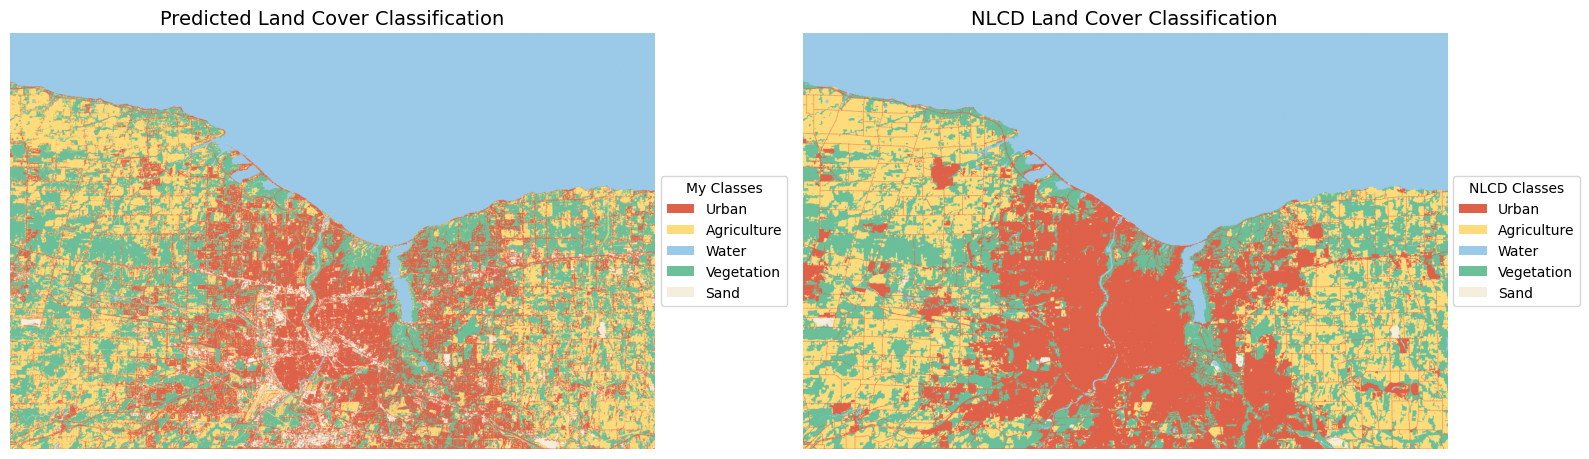

In [184]:
# Load NLCD Reclass image
nlcd_lc_path = '/content/drive/MyDrive/Colab_Files/GEE_Exports/MUSA650_final/nlcd_Reclass.tif'
with rasterio.open(nlcd_lc_path) as src:
    nlcd_lc = src.read(1)
    nlcd_transform = src.transform
    nlcd_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

# Create figure
plt.figure(figsize=(16, 8))

# Plot your classification (left)
plt.subplot(1, 2, 1)
plt.imshow(classified_map_int, cmap=cmap)
plt.title('Predicted Land Cover Classification', fontsize=14)

# Create legend for your classes
plt.legend(handles=legend_elements, title='My Classes', bbox_to_anchor=(1, 0.5), loc='center left')
plt.axis('off')

# Plot nlcd classification (left)
plt.subplot(1, 2, 2)
plt.imshow(nlcd_lc, cmap=plt.cm.colors.ListedColormap(class5_palette),
           extent=nlcd_extent, vmin=0, vmax=4)
plt.title('NLCD Land Cover Classification', fontsize=14)

# Create legend for your classes
plt.legend(handles=legend_elements, title='NLCD Classes', bbox_to_anchor=(1, 0.5), loc='center left')
plt.axis('off')

plt.tight_layout()
plt.show()

For this comparison, our prediction is in a 10m resolution, and the NLCD image is in a 30m resolution. Comparing the two plots, we can see that our model's result is very similar to nlcd data; it successfully captured most land cover in this region and in a finer resolution.

One thing that the model struggles about is distinguishing between urban and sand, which is as expected. The area that confused the model the most is the downtown area of Rochester, which is shown in the middle of the image. The buildings there are all pretty white in the satellite image, which looks the same as sand.